<a href="https://colab.research.google.com/github/arjunjyothieswarb/CS5180/blob/main/Assignment3/GTSAM_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gtsam
!pip install gtbook

In [230]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import gtsam
from gtbook.display import show
# %matplotlib inline

In [380]:
# import gtsam.noiseModel


class Mosaic_images_gt():

    def __init__(self, img_path):

        self.MIN_MATCH_COUNT = 10
        self.MATCH_DIST = 0.8

        self.TEMPORAL_COVAR_VAL = 200
        self.TEMPORAL_COVAR = np.ones(9)*self.TEMPORAL_COVAR_VAL
        self.TEMPORAL_COVAR[8] = 0

        self.SIDE_COVAR_VAL = 1000
        self.SIDE_COVAR = np.ones(9)*self.SIDE_COVAR_VAL
        self.SIDE_COVAR[8] = 0

        # Path of the folder that contains
        self.img_path = img_path
        # Reading all the images in the folder
        self.read_imgs(self.img_path)

        self.select_features(visualize=False)

        self.H_list = []
        self.H_corrected = []
        pass



    def get_graph(self):
        # self.get_matches(visualize=False)
        graph = gtsam.NonlinearFactorGraph()
        initial_estimates = gtsam.Values()

        priorMean = np.eye(3)
        priorMean = priorMean.reshape((9))
        # priorMean = np.zeros(9)
        priorNoise = gtsam.noiseModel.Diagonal.Sigmas(np.zeros(9))
        graph.add(gtsam.PriorFactorVector(0, priorMean, priorNoise))

        initial_estimates.insert(0, priorMean)
        # initial_estimates.insert(0, np.zeros(9))
        prev_H = priorMean

        # optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimates)
        # result = optimizer.optimize()

        temporal_noise = gtsam.noiseModel.Diagonal.Sigmas(self.TEMPORAL_COVAR)
        lateral_noise = gtsam.noiseModel.Diagonal.Sigmas(self.SIDE_COVAR)

        for i in range(self.N-1):

            # Get matches
            matches = self.get_matches(i, i+1)

            # Computing Homography
            new_H = self.find_homography(i+1, i, matches)
            self.H_list.append(new_H)

            new_H = new_H.reshape((9))

            if i==0:
                error = new_H - priorMean
            else:
                error = new_H - result.atVector(i)

            graph.add(gtsam.BetweenFactorVector(i, i+1, error, temporal_noise))

            j = i-1
            while(j > 0):

                # Computing the relative error
                error = error + (result.atVector(j+1) - result.atVector(j))

                # Checking for matches
                matches = self.get_matches(j, i+1)
                if(len(matches) > 10):
                    # Find homography for match
                    new_H = self.find_homography(i+1, j, matches)
                    new_H = new_H.reshape((9))
                    graph.add(gtsam.BetweenFactorVector(j, i+1, error, lateral_noise))

                j = j-1



            initial_estimates.insert(i+1, new_H)
            optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimates)

            prev_H = new_H

            result = optimizer.optimize()
            margins = gtsam.Marginals(graph, result)
            print(result.atVector(i))
            # show(graph)

            # new_H = new_H.reshape((9))
            # print(new_H.shape)
            # noise = gtsam.noiseModel.Diagonal.Sigmas(np.ones(9)*10)
            # graph.add(gtsam.BetweenFactorVector(i, i+1, new_H - prev_H, noise))

            # initial_estimates.insert(i+1, new_H)

            # optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimates)

            # prev_H = new_H

            # result = optimizer.optimize()
            # margins = gtsam.Marginals(graph, result)
            # print(result.atVector(i+1))

        for i in range(self.N-1):
            H = result.atVector(i+1)
            # H = H/H[8]
            H = H.reshape((3,3))
            print("Original:")
            print(self.H_list[i])
            print("Corrected:")
            print(H)
            print("==========X==========\n")

            self.H_corrected.append(H)

        pass


    def find_homography(self, src_index, dst_index, matches):

        if(len(matches) < self.MIN_MATCH_COUNT):
            print( "Not enough matches are found - {}/{}".format(len(matches), self.MIN_MATCH_COUNT))
            matchesMask = None
            return

        src_pts = np.float32([ self.kp[src_index][m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ self.kp[dst_index][m.queryIdx].pt for m in matches ]).reshape(-1,1,2)

        H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()

        return H

    def stitch_images(self):

        # self.select_features(visualize=False)
        # self.get_matches(visualize=False)

        H_act = np.eye(3)

        mosaic = self.imgs[0]

        for i in range(self.N-1):

            # Computing the Homographies between sequential images
            # H = self.find_homography(i+1, i)
            H = self.H_corrected[i]
            H_act = H @ H_act

            h,w,d = self.imgs[i+1].shape
            h2,w2,d2 = mosaic.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            transfomred_pts = cv.perspectiveTransform(pts, H_act)

            x_min = int(min(transfomred_pts[0][0][0], transfomred_pts[1][0][0], transfomred_pts[2][0][0], transfomred_pts[3][0][0], 0))
            y_min = int(min(transfomred_pts[0][0][1], transfomred_pts[1][0][1], transfomred_pts[2][0][1], transfomred_pts[3][0][1], 0))

            x_max = int(max(transfomred_pts[0][0][0], transfomred_pts[1][0][0], transfomred_pts[2][0][0], transfomred_pts[3][0][0], w2))
            y_max = int(max(transfomred_pts[0][0][1], transfomred_pts[1][0][1], transfomred_pts[2][0][1], transfomred_pts[3][0][1], h2))

            # Creating the canvas
            empty_canvas = np.zeros((y_max - y_min, x_max - x_min, 3), dtype=np.uint8)

            # X and Y off-set for the src img
            H_act[0, 2] = H_act[0, 2] - x_min
            H_act[1, 2] = H_act[1, 2] - y_min

            empty_canvas[-y_min:h2-y_min, -x_min:w2-x_min] = mosaic
            warped_img = cv.warpPerspective(self.imgs[i+1], H_act, (empty_canvas.shape[1], empty_canvas.shape[0]))

            warped_img_gray = cv.cvtColor(warped_img, cv.COLOR_BGR2GRAY)
            ret, mask = cv.threshold(warped_img_gray, 1, 255, cv.THRESH_BINARY_INV)
            mask = cv.cvtColor(mask, cv.COLOR_GRAY2BGR)
            empty_canvas = cv.bitwise_and(empty_canvas, mask)

            # mosaic = cv.addWeighted(empty_canvas, 0.8, warped_img, 0.8, -5.0)
            mosaic = empty_canvas + warped_img

            print(empty_canvas.shape)
            plt.figure()
            plt.imshow(mosaic)

        plt.show()
        pass



    def get_good_matches(self, matches):
        """Function to filter matches using Lowe's ratio test"""


        good = []

        for m,n in matches:
            if m.distance < self.MATCH_DIST*n.distance:
                good.append(m)

        return good

    def get_matches(self, index1, index2):
        """Function to get matches of features of the sequence of images.
           This function makes use of the K-Nearest Neighbour algorithm to
           identify the matches"""

        # Params for the match search
        # FLANN_INDEX_KDTREE = 1
        # index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        # search_params = dict(checks = 50)

        # Initializing Flann object
        # self.flann = cv.FlannBasedMatcher(index_params, search_params)
        self.bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)

        self.good_matches = []
        unfilt_imgs = []

        # matches = self.flann.knnMatch(self.des[i], self.des[i+1], k=2)
        # self.good_matches.append(self.get_good_matches(matches))

        matches = self.bf.match(self.des[index1], self.des[index2])
        matches = sorted(matches, key=lambda x:x.distance)

        return matches


    def get_matches_seq(self, visualize=False):
        """Function to get matches of features of the sequence of images.
           This function makes use of the K-Nearest Neighbour algorithm to
           identify the matches"""

        # Params for the match search
        # FLANN_INDEX_KDTREE = 1
        # index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        # search_params = dict(checks = 50)

        # Initializing Flann object
        # self.flann = cv.FlannBasedMatcher(index_params, search_params)
        self.bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)

        self.good_matches = []
        unfilt_imgs = []

        for i in range(self.N - 1):
            # matches = self.flann.knnMatch(self.des[i], self.des[i+1], k=2)
            # self.good_matches.append(self.get_good_matches(matches))

            matches = self.bf.match(self.des[i], self.des[i+1])
            matches = sorted(matches, key=lambda x:x.distance)
            self.good_matches.append(matches)

            unfilt_imgs.append(cv.drawMatches(self.imgs[i], self.kp[i], self.imgs[i+1], self.kp[i+1], self.good_matches[i], None))

        if visualize:
            self.display_imgs(unfilt_imgs, subplt=False)

    def select_features(self, visualize=False):
        """Function that uses SIFT descriptors to detect unique
           features in the list of images"""

        # Creating the SIFT object
        sift = cv.SIFT().create()
        self.kp = []
        self.des = []

        temp = []

        for i in range(self.N):

            # Storing the keypoints
            kp, des = sift.detectAndCompute(self.gray[i], None)
            self.kp.append(kp)
            self.des.append(des)

            # Storing the drawn images for displaying
            temp_img = cv.drawKeypoints(self.gray[i], self.kp[i], None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            temp.append(temp_img)

        # Displaying the images
        if visualize:
            self.display_imgs(temp)

    def read_imgs(self, folder):
        """Function used to read and store all the images present
           in the folder. Takes the folder path as its input"""

        self.imgs = []
        self.gray = []

        # Reading all the images in the folder
        filenames = [f for f in os.listdir(folder) if f.endswith(('.tif', '.jpg', '.png'))]  # Add other formats as needed
        filenames.sort(key=lambda x: int(os.path.splitext(x)[0]))  # Sort filenames numerically


        # Reading all the images in the folder
        for filename in filenames:
            img = cv.imread(os.path.join(folder, filename))

            if img is not None:

                # Storing the color image
                self.imgs.append(img)

                # Storing the grayscale image
                img_normalized = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_8U)
                # img_normalized = img_normalized * 255
                self.gray.append(img_normalized.astype(np.uint8))
                # self.gray.append(cv.cvtColor(img, cv.COLOR_BGR2GRAY))

        self.N = len(self.gray)

        self.H = [0] * self.N

    def display_imgs(self, images, subplt=True):
        """Function for development purpose, used to display
           an array of images in sequence"""

        if subplt:
            for i in range(len(images)):
                # cv.imshow("frame"+str(i), images[i])
                # cv.waitKey()
                plt.subplot(2,3,i+1)
                plt.imshow(images[i])
        else:
            for i in range(len(images)):
                plt.figure()
                plt.imshow(images[i])

        plt.show()

In [381]:
img_path = "drive/MyDrive/6Images"
Mosaic = Mosaic_images_gt(img_path)

In [382]:
Mosaic.get_graph()

[1. 0. 0. 0. 1. 0. 0. 0. 1.]
[ 1.00656134e+00  4.95205578e-02 -1.18028539e+01 -3.54235916e-02
  1.04114751e+00  1.34501065e+02 -1.33722960e-05  1.45066045e-04
  1.00000000e+00]
[ 9.64650657e-01  2.03045036e-02 -1.82884848e+01 -3.67352330e-02
  1.05294062e+00  1.36369700e+02 -6.53309552e-05  9.04354654e-05
  1.00000000e+00]
[ 7.41703501e-01 -8.12768657e-02 -2.37464464e+02  3.07368911e-02
  9.80649272e-01  5.26305363e+01 -1.60165105e-04  1.35964472e-04
  1.00000000e+00]
[ 9.85146706e-01 -5.51961822e-02  2.03573652e+01  1.60311409e-02
  9.37415345e-01 -1.09859686e+02  3.07887993e-05 -1.65084501e-04
  1.00000000e+00]
Original:
[[ 1.00656134e+00  4.95205578e-02 -1.18028539e+01]
 [-3.54235916e-02  1.04114751e+00  1.34501065e+02]
 [-1.33722960e-05  1.45066045e-04  1.00000000e+00]]
Corrected:
[[ 1.00656134e+00  4.95205574e-02 -1.18028540e+01]
 [-3.54235937e-02  1.04114751e+00  1.34501066e+02]
 [-1.33723025e-05  1.45066048e-04  1.00000000e+00]]
==========X==========

Original:
[[ 9.64652531e-01

(505, 587, 3)
(639, 603, 3)
(686, 854, 3)
(686, 915, 3)
(686, 930, 3)


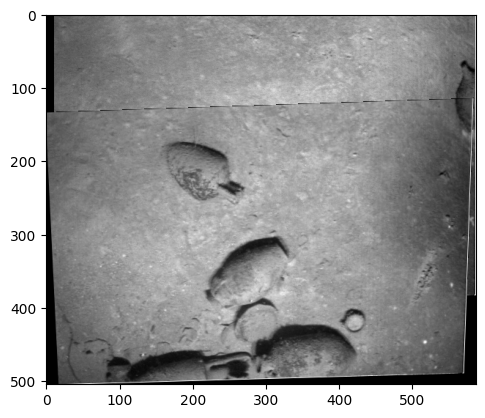

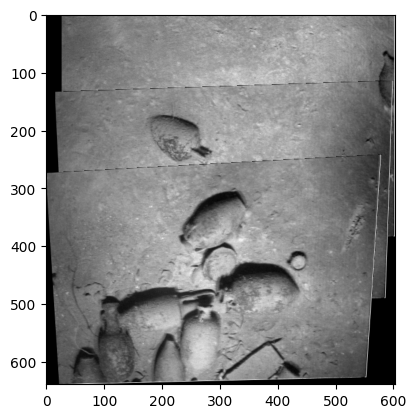

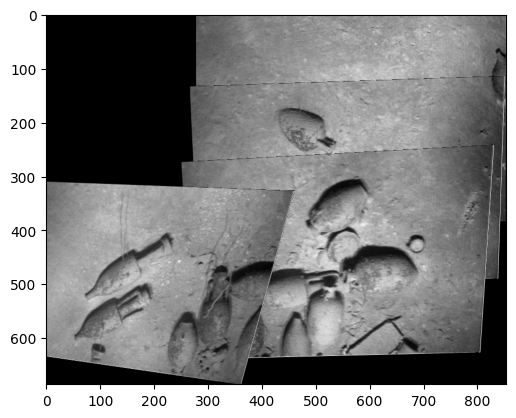

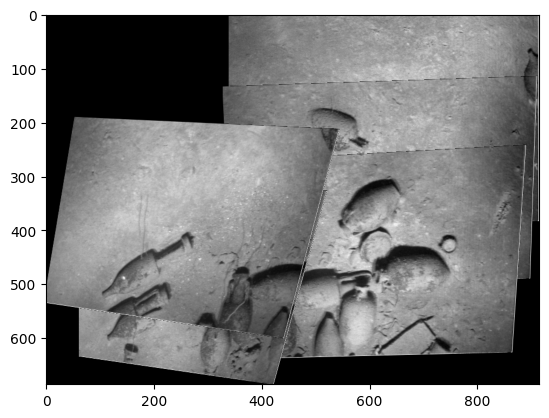

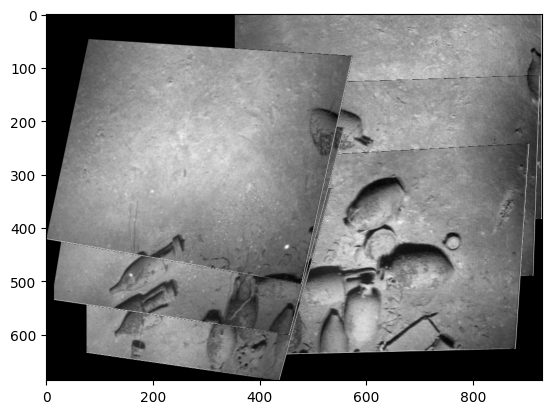

In [384]:
Mosaic.stitch_images()